In [1]:
import numpy as np
import gzip
import sys
import os
import time
import matplotlib.pyplot as plt
from multiprocessing import Process
import multiprocessing

#% matplotlib inline


# from scipy import integrate
# temp = np.genfromtxt("Ms_Mh_Vpeak.txt")
def _generic_open(f, buffering=100000000):
    """
    Returns
    -------
    fp : file handle
    need_to_close : bool
    """
    if hasattr(f, 'read'):
        return f, False
    else:
        if f.endswith('.gz'):
            fp = gzip.open(f, 'r')
        else:
            fp = open(f, 'r', int(buffering))
        return fp, True


def box_smooth(data_array):
    data_array = np.array(data_array)
    N = len(data_array)

    data_smooth = []

    for i in range(0, N):
        data_i = data_array[int(np.maximum(i - 1, 0)):int(np.minimum(i + 2, N))]
        # print(np.nanmean(data_i))

        data_smooth.append(np.nanmean(data_i))

    data_smooth = np.array(data_smooth).ravel()
    data_smooth[0] = np.nanmedian(data_array[:1])
    return data_smooth


try:
    parameters = open("sys.argv[1]", "r")
except:
    parameters = open("parameters.txt", "r")

count = 0
for line in parameters:
    if count == 1:
        file_name = line.replace("\n", "").split(" ")[0]
        box_size = float(line.replace("\n", "").split(" ")[1])
    if count == 3:
        halo_property = line.replace("\n", "").split(" ")[0]
        halo_col = int(line.replace("\n", "").split(" ")[1])
    if count == 5:
        output_col = line.replace("\n", "").split(" ")
    if count == 7:
        SMF_fusion = np.genfromtxt(line.replace("\n", ""))
    if count == 9:
        scatter_fusion = np.genfromtxt(line.replace("\n", ""))
    count += 1

# read data

print("Reading data, may take a while")
start_time = time.time()
hlist_data = np.genfromtxt(file_name)

print("Finish reading hlist data. Time we use %.2f seconds"%(time.time()-start_time))



Reading data, may take a while
Finish reading hlist data. Time we use 119.25 seconds


In [12]:


x = np.log10(hlist_data[:,halo_col])
# calculate SMF_cumu:
# remember the returned SMF_cumu is not in log space:
#smf_combine = np.poly1d(np.polyfit(SMF_fusion[:,0], SMF_fusion[:,1], 10))

def calculate_abundance_smf(threshold):
    ans = 0
    dx=0.02
    N = int((14-threshold)/0.02)
    for i in range(N):
        ans+=10**np.interp(x=threshold+i*dx,xp =SMF_fusion[:,0],fp=np.log10(SMF_fusion[:,1]))*dx
    ans = ans*(0.7**3)
    return ans
calculate_abundance_smf = np.vectorize(calculate_abundance_smf)



y_target = SMF_fusion[:,0]
# modify y_target a little bit and
y_low = min(y_target)-(max(y_target)-min(y_target))
y_high = max(y_target)+(max(y_target)-min(y_target))
y_target = np.linspace(y_low,y_high,100)
SMF_cumu_target = calculate_abundance_smf(y_target)

# calculate number density
x_low = np.nanpercentile(x,0)
x_high = np.nanpercentile(x,100)
x_target = np.linspace(x_low,x_high,100)


V = box_size**3
x_num = []
for i in range(len(x_target)):
    mask_i = x>x_target[i]
    x_num.append(len(x[mask_i]))
x_num = np.array(x_num)
index_x_min = np.argmin(abs(x_target-x_low))
x_cumu_target = x_num/V
x_cumu = np.interp(x=x,xp=x_target,fp = x_cumu_target)

index_y = np.argsort(SMF_cumu_target)
y = np.interp(x=x_cumu,xp=SMF_cumu_target[index_y],fp=y_target[index_y])

# Remember to label y<SMF_fusion[:,0] as nan
mask = y<np.nanmin(SMF_fusion[:,0])
y[mask] = np.nan

# tabulating the data
# Here we got scatter of sigma[Ms|halo_properties]
# we tabulate scatter from 0 to 1 with 0.01 bin size:

if np.nanmedian(x_target)<5:
    upper_s = 0.35
else:
    upper_s = 1


In [13]:
## remember this sorted index_x since we also need to recover the hlist later
index_x = np.argsort(x)
x = x[index_x]
y = y[index_x]


In [14]:
# use one thread per numpy thread:
from multiprocessing import Process
import multiprocessing
import mkl
import warnings
mkl.set_num_threads(1)

# warning 
warnings.filterwarnings('ignore')

In [15]:
### Do some debugging
# scatter array target:
scatter_array_target = np.linspace(0, upper_s, 80)

# debugging:
#scatter_array_target=[0]

Vpeak_log = x
Vpeak_log_target = x_target
Ms_all_log = y
Ms_log_target = y_target
y_Ms_V_all = []
time_start = time.time()
print("Start tabulating scatter. may take 10-20 minutes. Grab a Coffee")

mask_finite = np.isfinite(x + y)
poly_Ms_from_halo = np.poly1d(np.polyfit(x[mask_finite], y[mask_finite], 10))

### use multithreading in tabulating the scatter:
thread_to_use =48
#bin_size = len(scatter_array_target) // thread_to_use

my_pool = []

manager = multiprocessing.Manager()
final_results = manager.dict()



def helper(s):
 
    scatter = scatter_array_target[s]
    print("start thread %d"%s)

    scatter_array_all = []

    properties_log_scatter = np.zeros(len(Vpeak_log))
    scatter_array_logMh = []
    ## Vpeak scatter to Mpeak:
    Vpeak_log_i = Vpeak_log + np.random.normal(0, scatter, len(Vpeak_log))

    index = np.argsort(Vpeak_log_i)
    Ms_all_log_s = Ms_all_log[index]

    y_Ms_at_Vpeak = []
    

    for m in range(0, len(Vpeak_log_target)):

        mask_V = (Vpeak_log > Vpeak_log_target[m] - 0.1 * upper_s) & (Vpeak_log < Vpeak_log_target[m] + 0.1 * upper_s)
        #select_sample = Ms_all_log_s[mask_V] - poly_Ms_from_halo(Vpeak_log[mask_V])
        select_sample = Ms_all_log_s[mask_V]
        # print(np.nanstd(select_sample))

        if len(select_sample)>20:
            y_Ms_at_Vpeak.append((np.nanpercentile(select_sample,84)-np.nanpercentile(select_sample,16))/2)

        else:
            y_Ms_at_Vpeak.append(np.nan)

    # y_Ms_V_all.append(box_smooth(y_Ms_at_Vpeak))
    final_results[str(s)] = np.array(box_smooth(y_Ms_at_Vpeak))
    
# start threads:
for ni in range(0, len(scatter_array_target)):
    pi = Process(target=helper, args=(ni,))
    my_pool.append(pi)
    pi.start()
    
for ni in range(0, len(scatter_array_target)):
    my_pool[ni].join()

##Done
print("All threads done")


y_Ms_V_all = []
for i in range(0, len(scatter_array_target)):
    y_Ms_V_all.append(final_results[str(i)])

y_Ms_V_all = np.array(y_Ms_V_all)
print("Time we use for tabulating scatter %.2f seconds"%(time.time()-time_start))

# maybe we can save it :
np.savetxt("y_Ms_V_all.txt",y_Ms_V_all)



Start tabulating scatter. may take 10-20 minutes. Grab a Coffee
start thread 0
start thread 1
start thread 2
start thread 3
start thread 4
start thread 5
start thread 6
start thread 7
start thread 8
start thread 9
start thread 12
start thread 10
start thread 13
start thread 11
start thread 14
start thread 15
start thread 16
start thread 17
start thread 18
start thread 19
start thread 20
start thread 21
start thread 22
start thread 23
start thread 24
start thread 25
start thread 26
start thread 27
start thread 28
start thread 29
start thread 30
start thread 31
start thread 32
start thread 33
start thread 34
start thread 35
start thread 36
start thread 37
start thread 38
start thread 39
start thread 40
start thread 41
start thread 42
start thread 43
start thread 44
start thread 45
start thread 46
start thread 47
start thread 49
start thread 48
start thread 50
start thread 51
start thread 52
start thread 53
start thread 54
start thread 55
start thread 56
start thread 57
start thread 58
st

In [16]:

# calculate the scatter for V
V_scatter = []
scatter_y_interp = np.interp(x=Ms_log_target,xp=scatter_fusion[:,0],fp=scatter_fusion[:,1])
for i in range(len(Vpeak_log_target)):
    index_min = np.argmin(abs(scatter_y_interp[i]-y_Ms_V_all[:,i]))
    #print(index_min,Vpeak_log_target[i])
    V_scatter.append(scatter_array_target[index_min])
V_scatter = np.array(V_scatter)

print("Done")

Done


In [17]:
#plt.plot(Vpeak_log_target,V_scatter,"ko")

In [18]:

print("Adding scatter and saving files")



### sort and recover:
## recovery:
index_recovery = np.argsort(index_x)


V_scatter_per_halo = np.random.normal(0,np.interp(x=x,xp=Vpeak_log_target,fp=V_scatter))

index_Vpeak_2 = np.argsort(x+V_scatter_per_halo)

Ms_all_log_sort_i = y[index_Vpeak_2]
# recover:
Ms_all_log_scatter = Ms_all_log_sort_i[index_recovery]

# output:
## remember only output Ms>lower limit of SMF_fusion
mask_effective = Ms_all_log_scatter<np.nanmin(SMF_fusion[:,0])
Ms_all_log_scatter[mask_effective]=None
fusion_output = np.c_[Vpeak_log,Ms_all_log_scatter]

# save or not
#np.savetxt("output.txt",fusion_output)
print("All set!")


Adding scatter and saving files
All set!


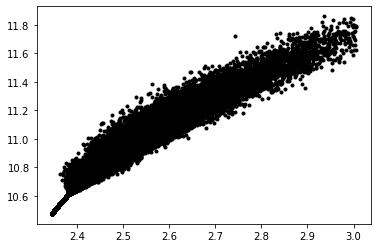

In [20]:

plt.plot(x[-50000:-100],Ms_all_log_sort_i[-50000:-100],"k.")

In [21]:
print("Done")

Done


In [ ]:
# read previous Vpeak results:
import pickle

if os.path.isdir("/Volumes/SSHD_2TB") == True:
    print("The code is on Spear of Adun")

    ## Move to Data_10TB
    data_path = "/Volumes/Data_10TB/"

elif os.path.isdir("/mount/sirocco1/jc6933/test") == True:
    data_path = "/mount/sirocco2/jc6933/Data_sirocco/"
    print("The code is on Sirocco")


# Gantrithor
elif os.path.isdir("/home/jc6933/test_Gantrithor") == True:
    data_path = "/mount/Gantrithor/Data_remote/"
    print("The code is on Gantrithor")

# Kratos
elif os.path.isdir("/home/jc6933/test_kratos") == True:
    data_path = "/mount/kratos/jc6933/Data/"
    print("The code is on Kratos")

# Void Seeker
elif os.path.isdir("/home/jc6933/test_Void_Seeker") == True:
    data_path = "/mount/Void_Seeker/Data_remote/"
    print("The code is on Void Seeker")

### PRINCE:
elif os.path.isdir("/home/jc6933/test_folder_prince") == True:
    data_path = "/scratch/jc6933/"
    print("The code is on PRINCE")

else:
    print("The code is on local")
    data_path = "/Volumes/Extreme_SSD/Data/"

print("data_path %s" % data_path)

pkl_file = open(data_path + "Vpeak/" + "Ms_array_C250_Vpeak_v1.pkl", 'rb')
Ms_all_log_prev = pickle.load(pkl_file)
pkl_file.close()


In [ ]:
print("Done")

In [ ]:

scatter=0.1
scatter_array_all = []

properties_log_scatter = np.zeros(len(Vpeak_log))
scatter_array_logMh = []
## Vpeak scatter to Mpeak:
Vpeak_log_i = Vpeak_log + np.random.normal(0, scatter, len(Vpeak_log))

index = np.argsort(Vpeak_log_i)
Ms_all_log_s = Ms_all_log[index]

y_Ms_at_Vpeak = []
mask_finite = np.isfinite(x+y)
poly_Ms_from_halo = np.poly1d(np.polyfit(x[mask_finite],y[mask_finite],10))


for m in range(0, len(Vpeak_log_target)):

    mask_V = (Vpeak_log > Vpeak_log_target[m] - 0.05 * 0.3) & (Vpeak_log < Vpeak_log_target[m] + 0.05 * 0.3)
    select_sample = Ms_all_log_s[mask_V] - poly_Ms_from_halo(Vpeak_log[mask_V])
    #print(np.nanstd(select_sample))


    try:
        y_Ms_at_Vpeak.append(np.nanstd(select_sample))

    except:
        y_Ms_at_Vpeak.append(np.nan)
print(y_Ms_at_Vpeak)

In [ ]:
print("Done")

In [ ]:
"""

print("Adding scatter and saving files")



### sort and recover:
index_Vpeak = np.argsort(x)

Vpeak_log_sort = Vpeak_log[index_Vpeak]
Ms_all_log_sort = Ms_all_log[index_Vpeak]

## recovery:
index_recovery = np.argsort(index_Vpeak)


V_scatter_per_halo = np.interp(x=Vpeak_log_sort,xp=Vpeak_log_target,fp=V_scatter)

index_Vpeak_2 = np.argsort(Vpeak_log_sort+V_scatter_per_halo)

Ms_all_log_sort_i = Ms_all_log_sort[index_Vpeak_2]
# recover:
Ms_all_log_scatter = Ms_all_log_sort_i[index_recovery]

# output:
## remember only output Ms>lower limit of SMF_fusion
mask_effective = Ms_all_log_scatter<np.nanmin(SMF_fusion[:,0])
Ms_all_log_scatter[mask_effective]=None
fusion_output = np.c_[Vpeak_log,Ms_all_log_scatter]

# save or not
#np.savetxt("output.txt",fusion_output)
print("All set!")




"""